# script - Feature set - E (5 feature model) ---- how feature selection take place! 

In [2]:
import sys
print(sys.version)

3.12.2 | packaged by conda-forge | (main, Feb 16 2024, 20:50:58) [GCC 12.3.0]


In [3]:
import sys
random_state = 23

In [10]:
#importing librariers
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sksurv.linear_model import CoxnetSurvivalAnalysis
from sksurv.util import Surv
from sklearn.preprocessing import StandardScaler
import pandas as pd
from sklearn.model_selection import train_test_split
from scipy.cluster import hierarchy
from scipy.spatial.distance import squareform
from scipy.stats import spearmanr
from collections import defaultdict
import warnings
from sklearn.exceptions import FitFailedWarning
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
warnings.simplefilter("ignore", UserWarning)
warnings.simplefilter("ignore", FitFailedWarning)
from sklearn.pipeline import make_pipeline
from sksurv.linear_model import CoxnetSurvivalAnalysis
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from sksurv.util import Surv
from sksurv.ensemble import RandomSurvivalForest

In [5]:
#reading the all dataset---
input_all = pd.read_csv("./../../Input.csv")

In [6]:
# Split the data into 70% training and 30% validation while stratifying by 'mRNA_Subtype'
train_df, val_df = train_test_split(input_all, test_size=0.30, stratify=input_all['mRNA_Subtype'], random_state=random_state)

In [7]:
#now i want to see the correlated features in train_df 
train_input = train_df[['Ki67', 'Size_cm', 'Age_at_surgery', 'CNA_Subtype_Chr12p13_amp', 'CNA_Subtype_Chr8p21_del',
              'CNA_Subtype_Chr9p23_amp', 'CNA_Subtype_Chr13q34_amp', 'CNA_Subtype_Chr20q13_amp', 'CNA_Subtype_Low_CIN', 
             'pr3004_huwe1', 'pr9001_cald1', 'pr12191_tank', 'pr19936_tpm4', 'pr41492_ftx' ]]

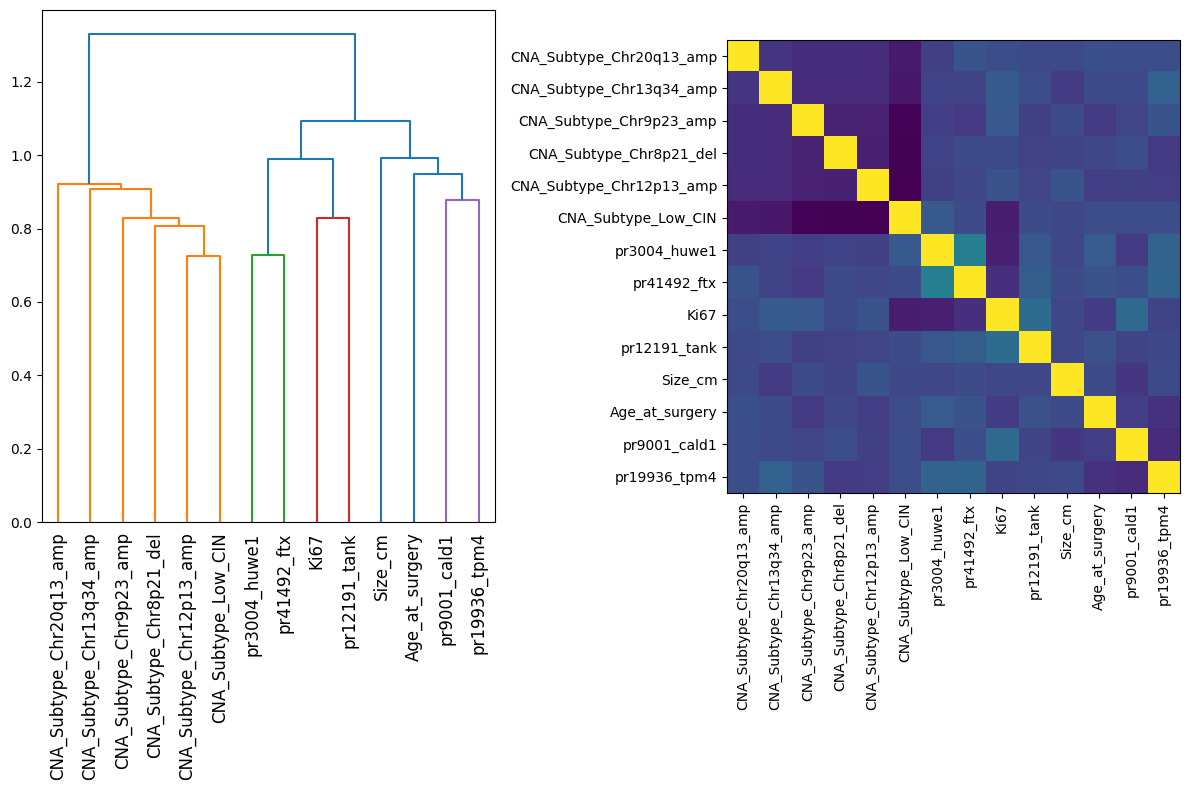

In [9]:
# ####now selecting the correlated features first and keeping only one among them
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 8))
corr = spearmanr(train_input).correlation
# print(corr)

# Ensure the correlation matrix is symmetric
corr = (corr + corr.T) / 2
np.fill_diagonal(corr, 1)

# We convert the correlation matrix to a distance matrix before performing
# hierarchical clustering using Ward's linkage.
distance_matrix = 1 - np.abs(corr)
dist_linkage = hierarchy.ward(squareform(distance_matrix))
dendro = hierarchy.dendrogram(
    dist_linkage, labels=train_input.columns.to_list(), ax=ax1, leaf_rotation=90
)
dendro_idx = np.arange(0, len(dendro["ivl"]))

ax2.imshow(corr[dendro["leaves"], :][:, dendro["leaves"]])
ax2.set_xticks(dendro_idx)
ax2.set_yticks(dendro_idx)
ax2.set_xticklabels(dendro["ivl"], rotation="vertical")
ax2.set_yticklabels(dendro["ivl"])
_ = fig.tight_layout()

In [11]:
cluster_ids = hierarchy.fcluster(dist_linkage, 0.75, criterion="distance")
cluster_id_to_feature_ids = defaultdict(list)
for idx, cluster_id in enumerate(cluster_ids):
    cluster_id_to_feature_ids[cluster_id].append(idx)

print(len(cluster_id_to_feature_ids))

#creating a dictionary taht have cluster id : and genes present in it !!!

from collections import defaultdict

cluster_ids = hierarchy.fcluster(dist_linkage, 0.75, criterion="distance")
cluster_id_to_feature_names = defaultdict(list)

for idx, cluster_id in enumerate(cluster_ids):
    feature_name = train_input.columns[idx]  # Get the feature name corresponding to the index
    cluster_id_to_feature_names[cluster_id].append(feature_name)

12


In [12]:
print(cluster_id_to_feature_names)
print(cluster_id_to_feature_ids)

defaultdict(<class 'list'>, {7: ['Ki67'], 12: ['Size_cm'], 11: ['Age_at_surgery'], 1: ['CNA_Subtype_Chr12p13_amp', 'CNA_Subtype_Low_CIN'], 2: ['CNA_Subtype_Chr8p21_del'], 3: ['CNA_Subtype_Chr9p23_amp'], 4: ['CNA_Subtype_Chr13q34_amp'], 5: ['CNA_Subtype_Chr20q13_amp'], 6: ['pr3004_huwe1', 'pr41492_ftx'], 9: ['pr9001_cald1'], 8: ['pr12191_tank'], 10: ['pr19936_tpm4']})
defaultdict(<class 'list'>, {7: [0], 12: [1], 11: [2], 1: [3, 8], 2: [4], 3: [5], 4: [6], 5: [7], 6: [9, 13], 9: [10], 8: [11], 10: [12]})


In [13]:
# Select 12 feature columns for X ----- FOR RUNNING LASSSO

X = train_df[['Ki67', 'Size_cm', 'Age_at_surgery', 'CNA_Subtype_Chr12p13_amp', 'CNA_Subtype_Chr8p21_del',
              'CNA_Subtype_Chr9p23_amp', 'CNA_Subtype_Chr13q34_amp', 'CNA_Subtype_Chr20q13_amp', 
             'pr3004_huwe1', 'pr9001_cald1', 'pr12191_tank', 'pr19936_tpm4' ]]
y = train_df[['RFS_Status', 'RFS_time_Months']]


In [201]:
#now convert the y(target matrix) in a structured array:
y_surv = Surv.from_dataframe('RFS_Status', 'RFS_time_Months', y) #false: 0, true: 1)
y_surv

array([(False,  48.3), (False,  38.3), (False,  59.3), (False,  37.4),
       (False,  78.1), (False,  45.8), ( True,   1.4), (False,  95.9),
       ( True,  43.5), ( True,  37.9), (False,   0.5), (False,  24.2),
       (False,  30.7), (False,  68.4), (False,  54.6), (False,  47.4),
       (False,  31.4), (False,  48. ), (False,  50.7), (False,  33.6),
       (False,  41.1), (False,  48.3), (False,  34.6), (False,  37.4),
       (False,  31. ), (False,  45.3), (False,  42.6), ( True,   9.4),
       (False,  30.2), (False,  50.3), (False,  46.5), (False,  41.8),
       (False,  34.6), (False,  61.4), (False,  32.9), ( True,  21.9),
       (False,  35.8), (False,  82.3), (False,  48. ), (False,   4.6),
       (False,  29.8), (False,  45.8), (False,  37. ), (False,  81.4),
       (False,  38.8), (False,  67.9), (False,  59.1), (False,  58. ),
       ( True,  30.9), ( True,  19.4), (False,  59.7), (False,  23.3),
       ( True,  33.1), (False,  50.9), (False,  57.3), (False,  57.4),
      

In [155]:
coxnet_pipe = make_pipeline(CoxnetSurvivalAnalysis(l1_ratio = 1.0, alpha_min_ratio = 0.001, max_iter=10000))

In [157]:
coxnet_pipe.fit(X, y_surv)

Pipeline(steps=[('coxnetsurvivalanalysis',
                 CoxnetSurvivalAnalysis(alpha_min_ratio=0.001, l1_ratio=1.0,
                                        max_iter=10000))])

In [158]:
coxnet_pipe.named_steps['coxnetsurvivalanalysis'].alphas_
estimated_alphas = coxnet_pipe.named_steps['coxnetsurvivalanalysis'].alphas_
print(len(estimated_alphas))

74


In [159]:
event_occurrences = y_surv['RFS_Status']
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from sksurv.util import Surv
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=random_state)

# Define a custom scoring function for C-index
def c_index_scorer(estimator, X, y):
    # y contains both the event occurrence and the time to event
    return concordance_index_censored(y['RFS_Status'], y['RFS_time_Months'], estimator.predict(X))[0]

gcv = GridSearchCV(
    make_pipeline(CoxnetSurvivalAnalysis(l1_ratio=1.0, alpha_min_ratio=0.001, max_iter=10000)),
    param_grid={"coxnetsurvivalanalysis__alphas": [[v] for v in estimated_alphas]},
    cv=cv.split(X, event_occurrences),
    error_score=0.5,
    n_jobs=1,
    verbose=1,
    scoring=c_index_scorer
).fit(X, y_surv)

Fitting 3 folds for each of 74 candidates, totalling 222 fits


In [160]:
print("Best Hyperparameters:", gcv.best_params_)
best_model = gcv.best_estimator_.named_steps["coxnetsurvivalanalysis"]

Best Hyperparameters: {'coxnetsurvivalanalysis__alphas': [0.0021280668549728435]}


In [161]:
best_index = gcv.best_index_

#evaluating the performance of model at each fold
cv_results = gcv.cv_results_
cv_results
fold_scores = {
    "Fold 1": cv_results[f'split0_test_score'][best_index],
    "Fold 2": cv_results[f'split1_test_score'][best_index],
    "Fold 3": cv_results[f'split2_test_score'][best_index]
}
# fold_scores
for fold, score in fold_scores.items():
    print(f"{fold} performance: {score}")

# Calculate and print the average performance across the 3 folds
average_performance = sum(fold_scores.values()) / len(fold_scores)
print(f"Average performance (Concordance Index) across 3 folds: {average_performance}")

Fold 1 performance: 0.7238493723849372
Fold 2 performance: 0.7700922266139657
Fold 3 performance: 0.7793493635077794
Average performance (Concordance Index) across 3 folds: 0.757763654168894


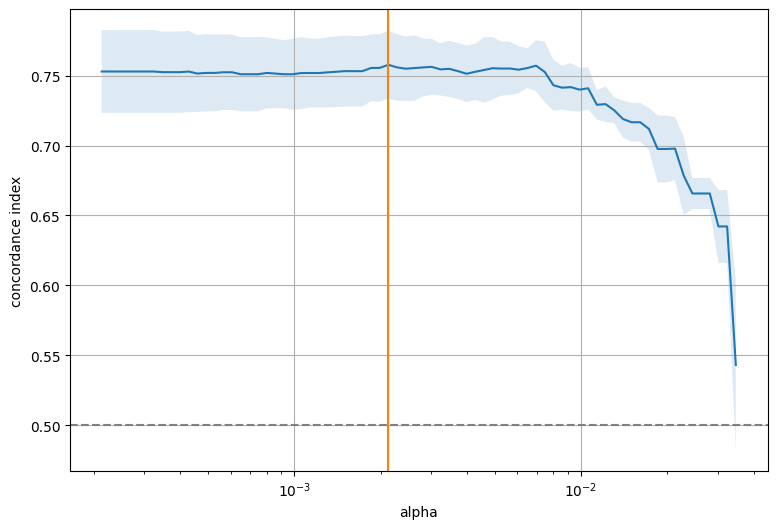

In [162]:
cv_results = pd.DataFrame(gcv.cv_results_)
alphas = cv_results.param_coxnetsurvivalanalysis__alphas.map(lambda x: x[0])
mean = cv_results.mean_test_score
std = cv_results.std_test_score

fig, ax = plt.subplots(figsize=(9, 6))
ax.plot(alphas, mean)
ax.fill_between(alphas, mean - std, mean + std, alpha=0.15)
ax.set_xscale("log")
ax.set_ylabel("concordance index")
ax.set_xlabel("alpha")
ax.axvline(gcv.best_params_["coxnetsurvivalanalysis__alphas"][0], c="C1")
ax.axhline(0.5, color="grey", linestyle="--")
ax.grid(True)

Number of non-zero coefficients: 12


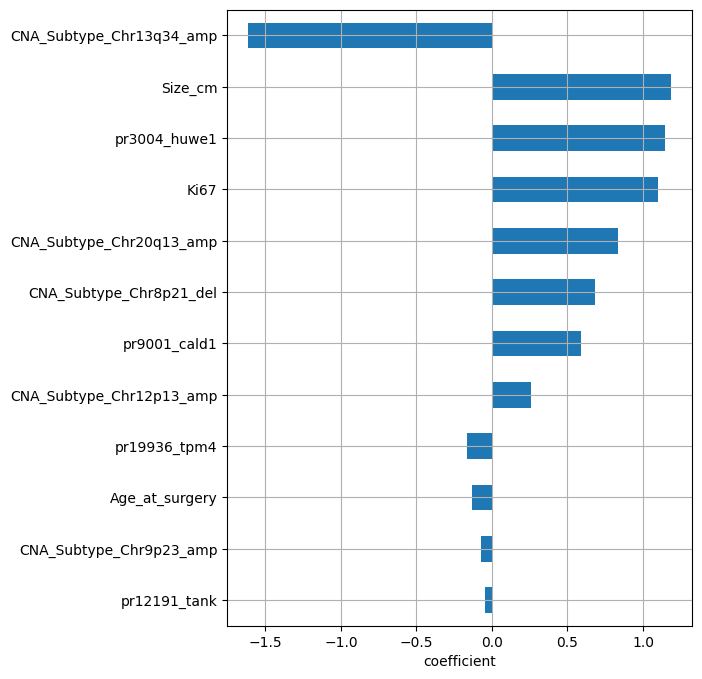

In [164]:
best_coefs = pd.DataFrame(best_model.coef_, index=X.columns, columns=["coefficient"])

non_zero = np.sum(best_coefs.iloc[:, 0] != 0)
print(f"Number of non-zero coefficients: {non_zero}")

non_zero_coefs = best_coefs.query("coefficient != 0")
coef_order = non_zero_coefs.abs().sort_values("coefficient").index

_, ax = plt.subplots(figsize=(6, 8))
non_zero_coefs.loc[coef_order].plot.barh(ax=ax, legend=False)
ax.set_xlabel("coefficient")
ax.grid(True)